<a href="https://colab.research.google.com/github/sahillakhmani/Natural-Language-Processing/blob/main/COVID-19%20Corpus%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Task 1**

In [ ]:
import os
import json
import gdown
import zipfile
from multiprocessing import Pool, cpu_count


# Step 1: Download the zipped corpus from Google Drive
def download_from_drive(drive_link, output_zip):
    gdown.download(drive_link, output_zip, quiet=False)

# Step 2: Extract the ZIP file
def extract_zip_file(zip_file, extract_to):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

def json2text(filename):
    """
    Converts the JSON content of a file into a plain text format.

    Args:
    filename (str): Path to the JSON file.

    Returns:
    str: Extracted text content from the JSON file.
    """
    try:
        with open(filename, 'r', encoding='utf-8') as file:
            paper_content = json.load(file)

        body_text = ""
        abstract = ""
        title = ""

        # Get the title
        if 'metadata' in paper_content and 'title' in paper_content['metadata']:
            title = paper_content['metadata']['title']

        # Get the abstract
        if 'abstract' in paper_content:
            for abs in paper_content['abstract']:
                abstract += abs.get('text', '')

        # Get the body text
        if 'body_text' in paper_content:
            for bt in paper_content['body_text']:
                body_text += bt.get('text', '')

        if title or abstract or body_text:
            return f"{title} {abstract} {body_text}".strip().lower()
        else:
            print(f"No content found in {filename}")
            return ""

    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return ""

def process_and_collect(filename):
    """
    Process a single JSON file and return the extracted text.

    Args:
    filename (str): Path to the JSON file.

    Returns:
    str: Extracted text content.
    """
    return json2text(filename)

def par_process_json_files(json_folder, output_file):
    """
    Process all JSON files in a directory using multiprocessing and write their contents to a text file.

    Args:
    json_folder (str): Path to the folder containing JSON files.
    output_file (str): Path to the output text file.
    """
    json_files = [os.path.join(json_folder, f) for f in os.listdir(json_folder) if f.endswith('.json')]

    if not json_files:
        print(f"No JSON files found in {json_folder}")
        return

    cpu_count_ = cpu_count()
    with Pool(cpu_count_) as pool:
        processed_contents = pool.map(process_and_collect, json_files)

    with open(output_file, 'w', encoding='utf-8') as outfile:
        for content in processed_contents:
            if content:  # Only write non-empty content
                outfile.write(content + '\n')

def main():
    drive_link = 'https://drive.google.com/uc?id=1PVA5IR4bAn7RulAeuSgxRBNMtmRGXaUm'
    output_zip = 'corpus.zip'
    extract_to = 'extracted_corpus'
    json_folder = r"/content/extracted_corpus/pdf_json"  # Replace with your folder path
    output_file = r'/content/drive/My Drive/processed_corpus.txt'  # Replace with your output file path

    download_from_drive(drive_link, output_zip)

    # Extract the ZIP file
    extract_zip_file(output_zip, extract_to)

    # Process the extracted JSON files
    par_process_json_files(json_folder, output_file)

    print(f"Processing complete. Output written to {output_file}")

if __name__ == "__main__":
    main()


Downloading...
From (original): https://drive.google.com/uc?id=1PVA5IR4bAn7RulAeuSgxRBNMtmRGXaUm
From (redirected): https://drive.google.com/uc?id=1PVA5IR4bAn7RulAeuSgxRBNMtmRGXaUm&confirm=t&uuid=67d6ca01-5b2a-46ff-b0e7-111eb09272e3
To: /content/corpus.zip
100%|██████████| 1.00G/1.00G [00:11<00:00, 86.1MB/s]


Processing complete. Output written to /content/drive/My Drive/processed_corpus.txt


**Task 2**

In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from multiprocessing import Pool, cpu_count

nltk.download('punkt')
nltk.download('stopwords')

def clean_text_chunk(text_chunk):
    # Remove HTML tags using regular expressions
    text_chunk = re.sub(r'<[^>]+>', '', text_chunk)

    # Remove numbers
    text_chunk = re.sub(r'\d+', '', text_chunk)

    # Remove punctuation
    text_chunk = text_chunk.translate(str.maketrans('', '', string.punctuation))

    # Tokenize text
    words = word_tokenize(text_chunk)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    cleaned_words = [word for word in words if word.lower() not in stop_words]

    # Join words back into a string
    cleaned_text = ' '.join(cleaned_words)

    return cleaned_text

def process_large_file(input_file, output_file, chunk_size=1024*1024):
    # Read the input file in chunks
    with open(input_file, 'r', encoding='utf-8') as file:
        text_chunks = []
        while True:
            chunk = file.read(chunk_size)
            if not chunk:
                break
            text_chunks.append(chunk)

    # Use multiprocessing to clean text chunks in parallel
    with Pool(cpu_count()) as pool:
        cleaned_chunks = pool.map(clean_text_chunk, text_chunks)

    # Write the cleaned text to the output file
    with open(output_file, 'w', encoding='utf-8') as file:
        for cleaned_chunk in cleaned_chunks:
            file.write(cleaned_chunk)

    print(f"Cleaned text has been saved to {output_file}")


input_file = '/content/drive/MyDrive/processed_corpus.txt'
output_file = '/content/drive/MyDrive/final_output.txt'
process_large_file(input_file, output_file)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Cleaned text has been saved to /content/drive/MyDrive/final_output.txt


**Task 3**

In [ ]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def power_law(x, alpha, c):
    return c * (x ** (-alpha))

def calculate_weighted_term_frequency(word_counts, total_words):
    # Calculate the weighted term frequency for each word
    weighted_tf = {word: count / total_words for word, count in word_counts.items()}
    return weighted_tf

def estimate_zipfs_alpha(file_path):
    try:
        with open(file_path, 'r') as file:
            text = file.read().lower()

        # Tokenize the text into words (you can use a more sophisticated tokenizer if needed)
        words = text.split()
        total_words = len(words)

        # Count the frequency of each word
        word_counts = Counter(words)

        # Calculate the weighted term frequency for each word
        weighted_tf = calculate_weighted_term_frequency(word_counts, total_words)

        # Sort the words by weighted term frequency (descending order)
        sorted_words = sorted(weighted_tf.items(), key=lambda item: item[1], reverse=True)

        # Extract the ranks and frequencies
        ranks = np.arange(1, len(sorted_words) + 1)
        frequencies = np.array([freq for _, freq in sorted_words])

        # Fit the power law to the data
        params, covariance = curve_fit(power_law, ranks, frequencies)

        # Extract the alpha value
        alpha = params[0]
        c = params[1]

        # Plot the fitted line
        fitted_values = power_law(ranks, alpha, c)

        print(f"Estimated Zipf's alpha: {alpha:.2f}")

    except FileNotFoundError:
        print(f"The file {file_path} was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

file_path = '/content/drive/MyDrive/final_output.txt'
estimate_zipfs_alpha(file_path)


Estimated Zipf's alpha: 0.62


**Task 4**

In [ ]:
from collections import Counter

def print_tokens_and_vocabulary(file_path):
    try:
        with open(file_path, 'r') as file:
            text = file.read().lower()

        # Tokenize the text into words (you can use a more sophisticated tokenizer if needed)
        words = text.split()

        # Calculate the number of tokens (total words)
        total_words = len(words)

        # Calculate the vocabulary (unique words)
        unique_words = set(words)
        vocabulary_size = len(unique_words)

        # Print the number of tokens and the vocabulary size
        print(f"Number of tokens (total words): {total_words}")
        print(f"Vocabulary size (unique words): {vocabulary_size}")

    except FileNotFoundError:
        print(f"The file {file_path} was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

file_path = '/content/drive/MyDrive/final_output.txt'
print_tokens_and_vocabulary(file_path)


Number of tokens (total words): 65610910
Vocabulary size (unique words): 1311523


**Task 5**

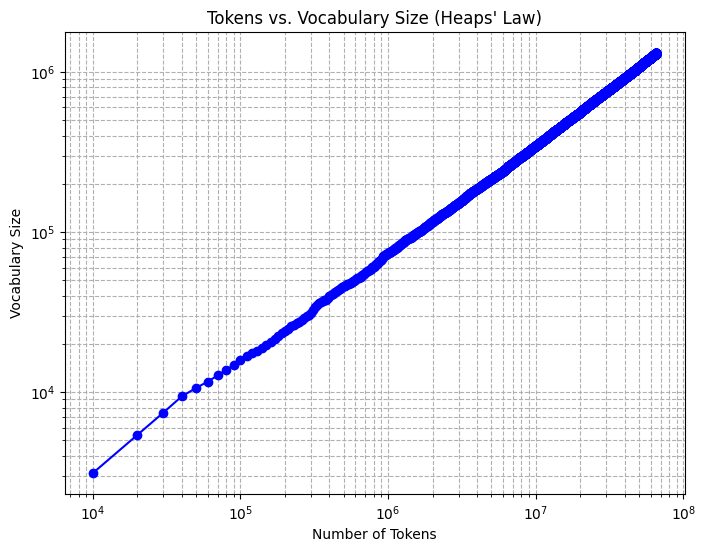

Streaming output truncated to the last 5000 lines.
Tokens: 15630000, Vocabulary Size: 473473
Tokens: 15640000, Vocabulary Size: 473620
Tokens: 15650000, Vocabulary Size: 473787
Tokens: 15660000, Vocabulary Size: 473982
Tokens: 15670000, Vocabulary Size: 474136
Tokens: 15680000, Vocabulary Size: 474528
Tokens: 15690000, Vocabulary Size: 474760
Tokens: 15700000, Vocabulary Size: 474945
Tokens: 15710000, Vocabulary Size: 475084
Tokens: 15720000, Vocabulary Size: 475216
Tokens: 15730000, Vocabulary Size: 475423
Tokens: 15740000, Vocabulary Size: 475560
Tokens: 15750000, Vocabulary Size: 475788
Tokens: 15760000, Vocabulary Size: 476044
Tokens: 15770000, Vocabulary Size: 476216
Tokens: 15780000, Vocabulary Size: 476347
Tokens: 15790000, Vocabulary Size: 476502
Tokens: 15800000, Vocabulary Size: 476874
Tokens: 15810000, Vocabulary Size: 477245
Tokens: 15820000, Vocabulary Size: 477583
Tokens: 15830000, Vocabulary Size: 478261
Tokens: 15840000, Vocabulary Size: 478574
Tokens: 15850000, Vocabul

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_tokens_vs_vocabulary(file_path, step=10000):
    try:
        with open(file_path, 'r') as file:
            text = file.read().lower()

        # Tokenize the text into words (you can use a more sophisticated tokenizer if needed)
        words = text.split()

        total_tokens = len(words)
        vocabulary_sizes = []
        tokens_list = []

        # Calculate vocabulary size at each step
        unique_words = set()
        for i in range(0, total_tokens, step):
            tokens_list.append(i + step)
            unique_words.update(words[i:i+step])
            vocabulary_sizes.append(len(unique_words))

        # Plot Tokens vs. Vocabulary Size using a log-log scale
        plt.figure(figsize=(8, 6))
        plt.loglog(tokens_list, vocabulary_sizes, marker='o', linestyle='-', color='b')
        plt.xlabel('Number of Tokens')
        plt.ylabel('Vocabulary Size')
        plt.title("Tokens vs. Vocabulary Size (Heaps' Law)")
        plt.grid(True, which="both", ls="--")
        plt.show()

        # Optionally, print the vocabulary sizes for every step
        for i, vocab_size in enumerate(vocabulary_sizes):
            print(f"Tokens: {tokens_list[i]}, Vocabulary Size: {vocab_size}")

    except FileNotFoundError:
        print(f"The file {file_path} was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

file_path = '/content/drive/MyDrive/final_output.txt'
plot_tokens_vs_vocabulary(file_path, step=10000)
